In [1]:
#instantiate and load overlay
from pynq import Overlay

#note the .bit file must have the same name as the .hwh and .tcl file
adc_interface = Overlay("adc_interface.bit")

In [2]:
#verify that overlay is loaded
print(adc_interface.is_loaded())

True


In [3]:
#print address mapped modules present in overlay (optional)
print(adc_interface.ip_dict.keys())

dict_keys(['axi_registers', 'processing_system7_0'])


In [4]:
#create an alias for the axi_registers module
axi_port = adc_interface.axi_registers

In [5]:
"""
The axi registers module contains the following registers with the following bits:

Address 0 (read-only):
    heartbeat_counter - This register increments every clock cycle to indicate operation of the PL with the following
                        bits:
        heartbeat_counter[31:0] - heartbeat counter value. This value increments every clock cycle on the PL clock
                                  domain.

Address 1 (read-only):
    adc_test_data - This register contains the data output from the XADC module connected to the DAQ module. This
                    can be used to read data directly from the ADC without using the DAQ FIFO to buffer data. This
                    value represents measurements from the V_P and V_N inputs. This register uses the following bits:
        adc_test_data[15:0] - output data from XADC module connected to DAQ module
        adc_test_data[31:16] - unused

Address 2 (read-only):
    adc_valid_counter - This register increments every time a valid signal is recieved from the XADC axi-stream port.
                        This can be used to confirm operation of the XADC output data port. The following bits are used:
        adc_valid_counter[31:0] - adc valid counter value. This value is incremented when the DAQ XADC module axi-stream
                                  valid signal is asserted.
    
Address 3 (read-only):
    adc_busy_counter - This register increments every time the DAQ XADC module busy_out signal is asserted. This can be
                       used to confirm that the XADC module is successfully performing analog-to-digital conversions.
                       This register uses the following bits
       adc_busy_counter[31:0] - adc busy counter value. This value is incremented when the DAQ XADC module busy_out
                                signal is asserted.

Address 4 (read-only):
    daq_status_reg  - The general status of the daq is communicated via the following bits in the daq_status_reg:
        daq_status_reg[15:0] - daq_event_counter incremented every time an event is recorded
        daq_status_reg[16]   - threshold flag that is set if the adc value is triggering the daq (exceeding the 
                               threshold in the positive or negative direction as defined by bits  13 and 11:0 in the 
                               daq_control_register), this bit will clear as soon as the adc value is no longer 
                               triggering the daq
        daq_status_reg[17]   - threshold flag sticky bit that is set if the adc value triggers the daq and only cleared 
                               by the user via the daq_control_reg
        daq_status_reg[18]   - fifo empty
        daq_status_reg[19]   - fifo full
        daq_status_reg[20]   - fifo_data_req_ack, this signal is set when the output fifo data is  updated following a
                               new data req from the PS

Address 5 (read-only):
    daq_fifo_data_reg - This register contains data read from the DAQ FIFO. Data can be loaded
                        into this register via a PS-PL handshake performed using the daq_control_reg
                        and the daq_status_reg. The following bits are used:
        daq_fifo_data_reg[31:0] - The latest data value read from the DAQ FIFO.
                               
Address 128 (write/read):
    daq_control_reg - The general operation of the DAQ is controlled by the following bits in the daq_control_reg:
                      
        daq_control_reg[11:0] - adc threshold value in twos-compliment. This controls which values above or below which 
                                the data from the adc is considered valid
        daq_control_reg[12]   - adc threshold write enable, when set, the threshold value from this register will be 
                                written into the daq threshold regisgers                        
        daq_control_reg[13]   - this controls whether valid data is above or below the threshold 0 indicates that data
                                must be above the threshold, while 1 indicates that it must be below the threshold.
        daq_control_reg[14]   - threshold direction write enable, when set the value from                      
        daq_control_reg[15]   - Setting this bit will clear all sticky bits in the daq_status_register
        daq_control_reg[16]   - Setting this bit will reset the trigger counter in the daq_status_register
        daq_control_reg[17]   - fifo_reset, setting this bit will reset the data fifo (i.e. reset write and read 
                                pointers)
        daq_control_reg[18]   - fifo_data_req, this bit is set by the PS when it wants to load a new value from the fifo 
                                into fifo_data_reg
        daq_control_reg[19]   - fifo_data_ack, this bit is set to indicate the PS has read the value currently held in 
                                the fifo_data_reg
                                
    Attempting to write or read addresses other than those listed above will do nothing or return 0
"""

#readout entire 8-bit address space and print values
for addr in range(0,255):
    read_value = axi_port.read(addr*4)
    print('value read from address ' + str(addr) + ' is the following: ' + bin(read_value))

value read from address 0 is the following: 0b110010001110101110111110000001
value read from address 1 is the following: 0b1111111111100010
value read from address 2 is the following: 0b11110111011011001011011
value read from address 3 is the following: 0b11110111011011110001100
value read from address 4 is the following: 0b10101001010100011001
value read from address 5 is the following: 0b0
value read from address 6 is the following: 0b0
value read from address 7 is the following: 0b0
value read from address 8 is the following: 0b0
value read from address 9 is the following: 0b0
value read from address 10 is the following: 0b0
value read from address 11 is the following: 0b0
value read from address 12 is the following: 0b0
value read from address 13 is the following: 0b0
value read from address 14 is the following: 0b0
value read from address 15 is the following: 0b0
value read from address 16 is the following: 0b0
value read from address 17 is the following: 0b0
value read from addre

In [6]:
#declare some functions to help control and read data from the DAQ in the PL

import matplotlib.pyplot as plt
import matplotlib as mpl
import time

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val                         # return positive value as is


def write_daq_threshold(threshold, direction):
    """
    This function assign a threshold and a threshold direction to the daq_control_register and set write-enable bits.
    threshold - is 12-bit two's complement value compared to the current DAQ ADC value and used to trigger
                the DAQ. When triggered, the DAQ will set the threshold flag, increment the event counter,
                and save adc values to the FIFO.
    direction - is a single-bit value indicating whether the ADC value must be greater than or less than the 
                threshold value to trigger the DAQ. 0 means greater than, 1 means less than
    """
    axi_port.write(128*4, (1 << 14)|((direction) << 13)| (1 << 12) | (threshold & 0b111111111111))
    
def clear_daq_sticky_bits():
    """
    This function clears the threshold flag sticky bit in the daq_status_reg by setting the clear_sticky_bits bit
    in the daq_control_reg
    """
    axi_port.write(128*4, (1 << 15))
    axi_port.write(128*4, (0 << 15))
    
def clear_daq_event_counter():
    """
    This function clears the daq event counter in the daq_status_reg by setting the reset trigger counter bit in
    the daq_control_reg
    """
    axi_port.write(128*4, (1 << 16))
    axi_port.write(128*4, (0 << 16))

def reset_daq_fifo():
    """
    This function resets the FIFO (i.e. clears existing data by resetting write and read pointers) by setting the
    reset fifo bit in the daq_control_reg
    """
    axi_port.write(128*4, (1 << 17))
    axi_port.write(128*4, (0 << 17))
    
def is_fifo_empty():
    """
    This funciton checks if the DAQ fifo is empty by reading the fifo empty signal from the daq_status_reg.
    Returns True if the FIFO is empty, False otherwise
    """
    #read daq_status_reg
    addr = 4
    daq_status_reg_value = axi_port.read(4*addr)
    #check if bit 18 is set
    if (daq_status_reg_value & (1 << 18)) == 0:
        return False
    else:
        return True

def read_next_fifo_value():
    """
    This function reads the next value from the DAQ FIFO. This utilizes the following sequence to request new data,
    read new data, and complete the PS-PL handshake:
        1. The PS sets the fifo_data_req signals and clears the fifo_data_ack signal to request a new value from the FIFO
        2. The PL reads the next value from the FIFO, assigns it to the fifo_data_reg, and sets the fifo_req_ack signal
           to indicate that the requested FIFO value has been written to the fifo_data_reg
        3. The PS reads the fifo_data_reg, clears the fifo_data_req signal, and asserts the fifo_data_ack signal to indicate
           that the new FIFO value has been read from the fifo_data_reg
        4. The PL clears the fifo_req_ack bit
        5. The PS clears the fifo_data_ack bit
    The PL will not write a new value to the fifo_data_reg until the previous handshake has been completed and a new value is
    requested by the PS.
    
    Once a new value is read, the function returns it. If no value can be read, a None type is returned
    """
    #make sure FIFO isn't empty, else read the next value from the FIFO using the handshake protocol
    if is_fifo_empty():
        #print('no new data to read, returning none!')
        return None
    else:
        #request data from fifo by asserting the data_req bit (bit 18) in the daq_control_reg (addr 128)
        axi_port.write(128*4, (0 << 19)|(1 << 18))
        #wait for the data_req_ack bit to get set in the daq_status_reg (bit 20 addr 4), this should basically be immediate 
        while ((axi_port.read(4*4) & (1 << 20)) == 0):
            pass
        #once the data_req_ack bit is set, read the value from the daq_fifo_data_reg (addr 5)
        next_fifo_value = axi_port.read(5*4)
        #print('next value read from fifo: ' + str(next_fifo_value))
        #clear the data_req bit and set the data_ack bit (bit 19 of addr 128)
        axi_port.write(128*4, (1 << 19)|(0 << 18))
        #wait for the data_req_ack bit to clear
        while (not ((axi_port.read(4*4) & (1 << 20)) == 0)):
            pass
        #clear the data_ack bit
        axi_port.write(128*4, (1 << 19)|(0 << 18))
        #return the new fifo value
        return next_fifo_value
    
def drain_fifo():
    """
    This function reads all data in the FIFO into a list and returns the list.
    If no data was in the FIFO, the returned list will contain a single None-type
    """
    new_data = read_next_fifo_value()
    fifo_data = []
    n_fifo_data_points = 0
    while (not(new_data == None)):
        fifo_data.append(new_data)
        new_data = read_next_fifo_value()
        n_fifo_data_points += 1
    print('retrieved ' + str(n_fifo_data_points) + ' data points from the FIFO!')
    return fifo_data

def plot_fifo_data():
    """
    This function drains the FIFO and creates and saves a scatter plot of the data. The plotted data is then
    returned as a list
    """
    fifo_data = drain_fifo()
    n_data_points = len(fifo_data)
    x_values = []
    if n_data_points == 0:
        print('FIFO is empty, no data to plot.')
    else:
        #convert to 2's compliment
        for i in range(0, n_data_points):
            x_values.append(i)
            fifo_data[i] = twos_comp(fifo_data[i], 12)
        plt.figure(1)
        plt.scatter(x_values,fifo_data)
        plt.savefig('plots/fifo_data_' + str(time.time()) + '.png')
        plt.show()
    return fifo_data

In [17]:
#declare functions to run fixed event-count and fixed time interval experiments

import numpy as np
import time

def fixed_event_count_experiment(n_events = 100, threshold=0b111111100111, threshold_direction=1):
    """
    This function will run an experiment until it has accumulated a fixed number of events. An event is
    defined as the number of times the FIFO has to drain. This assumes that events will be spaced sufficiently
    apart that there will be ample time to drain the FIFO between events. This is generally true when measuring
    background and low-level sources, but not stronger sources.
    
    Inputs:
        -n_events - the number of events to accumulate
        -threshold - 12 bit two's complement number for threshold the ADC value
        -threshold_direction - 1 if the ADC value must be less than the threshold to trigger the DAQ, else 0
    
    Outputs:
        -scatter plot of each event is saved
        -all event data is saved to a numpy array
            -the array is a list of events with timestamps
                -each event is a list of ADC values
            -e.g. [[event1_time_stamp,[event1_data]]<,[event2_time_stamp,[event2_data]]...>]
    """
    # accumulate max_event_number events and save the FIFO data to help determine if they were from noise or not
    event_count = 0
    print('Beginning accumulation of ' + str(n_events) + ' events!!')
    #reset the FIFO before beginning the experiment
    write_daq_threshold(threshold, threshold_direction)
    clear_daq_sticky_bits()
    clear_daq_event_counter()
    reset_daq_fifo()
    #store an list of event data
    experiment_data = []
    start_time = time.time()
    while event_count < n_events:
        #if there is data in the FIFO
        if not (is_fifo_empty()):
            #increment the event counter
            event_count += 1
            print('new event captured! Event Counter: ' + str(event_count))
            #drain the fifo, plot the data, save the plot with a timestamp
            event_data = plot_fifo_data()
            experiment_data.append([time.time(),event_data])
            #save the experiment data
            np.save('plots/experiment_data_' + str(start_time) + '.npy', np.array(experiment_data,dtype=object), allow_pickle = True)
            
            
def fixed_time_experiment(n_seconds = 3600, threshold=0b111111100111, threshold_direction=1):
    """
    This function will run an experiment until it has accumulated a fixed number of events. An event is
    defined as the number of times the FIFO has to drain. This assumes that events will be spaced sufficiently
    apart that there will be ample time to drain the FIFO between events. This is generally true when measuring
    background and low-level sources, but not stronger sources.
    
    Inputs:
        -n_seconds - the number of seconds to accumulate events for
        -threshold - 12 bit two's complement number for threshold the ADC value
        -threshold_direction - 1 if the ADC value must be less than the threshold to trigger the DAQ, else 0
    
    Outputs:
        -scatter plot of each event is saved
        -all event data is saved to a numpy array
            -the array is a list of events with timestamps
                -each event is a list of ADC values
            -e.g. [[event1_time_stamp,[event1_data]]<,[event2_time_stamp,[event2_data]]...>]
    """
    # accumulate max_event_number events and save the FIFO data to help determine if they were from noise or not
    event_count = 0
    print('Beginning accumulation of events for ' + str(n_seconds) + ' seconds!!')
    
    #assign the threshold and threshold direction for the experiment
    write_daq_threshold(threshold, threshold_direction)
    #reset the FIFO before beginning the experiment
    clear_daq_sticky_bits()
    clear_daq_event_counter()
    reset_daq_fifo()
    #store an list of event data
    experiment_data = []
    start_time = time.time()
    while (time.time() - start_time) < n_seconds:
        #if there is data in the FIFO
        if not (is_fifo_empty()):
            #increment the event counter
            event_count += 1
            print('new event captured! Event Counter: ' + str(event_count))
            print('The experiment duration is now up to ' + str(time.time() - start_time) + ' seconds!')
            #drain the fifo, plot the data, save the plot with a timestamp
            event_data = plot_fifo_data()
            experiment_data.append([time.time(),event_data])
            #save the experiment data
            np.save('plots/experiment_data_' + str(start_time) + '.npy', np.array(experiment_data,dtype=object), allow_pickle = True) 

Beginning accumulation of events for 14400 seconds!!
new event captured! Event Counter: 1
The experiment duration is now up to 36.493122816085815 seconds!
retrieved 560 data points from the FIFO!


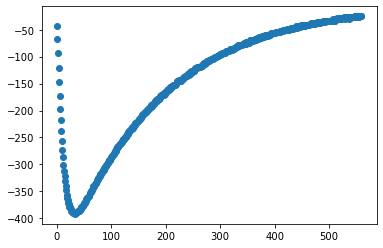

new event captured! Event Counter: 2
The experiment duration is now up to 251.69773268699646 seconds!
retrieved 426 data points from the FIFO!


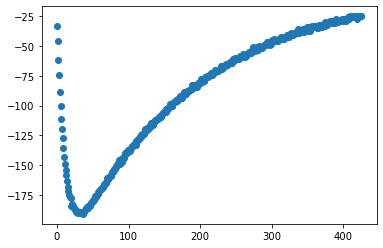

new event captured! Event Counter: 3
The experiment duration is now up to 296.37551617622375 seconds!
retrieved 448 data points from the FIFO!


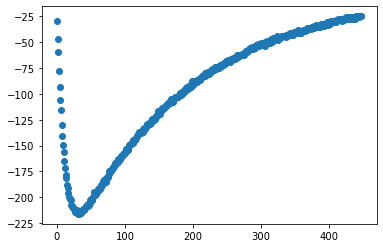

new event captured! Event Counter: 4
The experiment duration is now up to 637.2444534301758 seconds!
retrieved 506 data points from the FIFO!


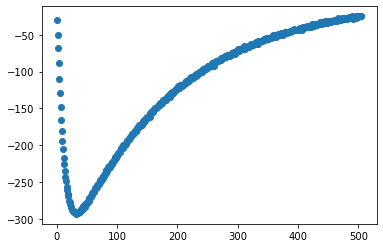

new event captured! Event Counter: 5
The experiment duration is now up to 848.0275747776031 seconds!
retrieved 425 data points from the FIFO!


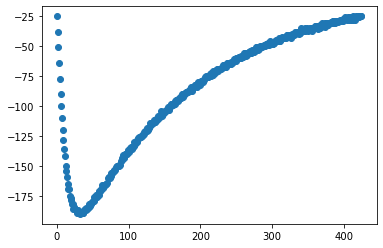

new event captured! Event Counter: 6
The experiment duration is now up to 912.729542016983 seconds!
retrieved 476 data points from the FIFO!


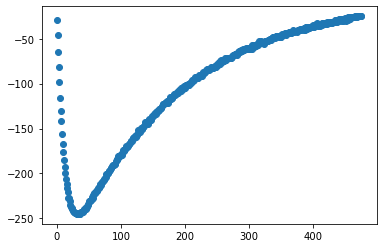

new event captured! Event Counter: 7
The experiment duration is now up to 1102.8010773658752 seconds!
retrieved 619 data points from the FIFO!


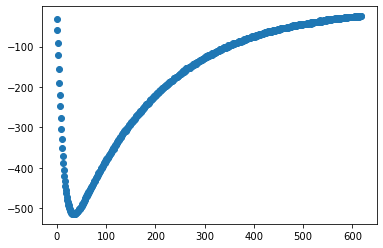

new event captured! Event Counter: 8
The experiment duration is now up to 1137.4631509780884 seconds!
retrieved 548 data points from the FIFO!


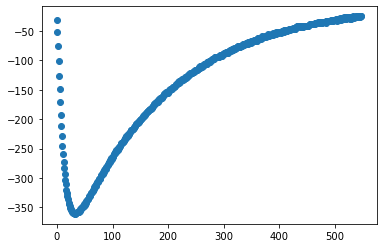

new event captured! Event Counter: 9
The experiment duration is now up to 1411.8711862564087 seconds!
retrieved 442 data points from the FIFO!


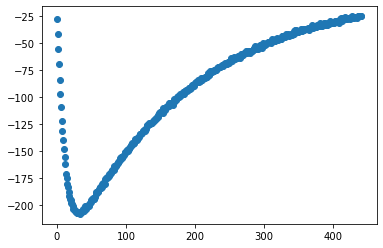

new event captured! Event Counter: 10
The experiment duration is now up to 1730.2386605739594 seconds!
retrieved 640 data points from the FIFO!


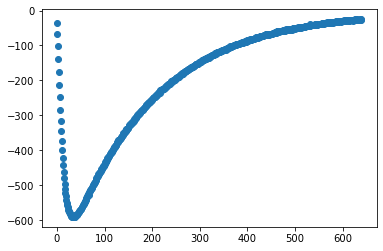

new event captured! Event Counter: 11
The experiment duration is now up to 1774.832265138626 seconds!
retrieved 625 data points from the FIFO!


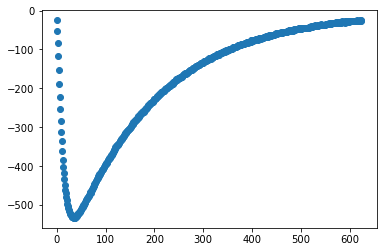

new event captured! Event Counter: 12
The experiment duration is now up to 1795.6947002410889 seconds!
retrieved 245 data points from the FIFO!


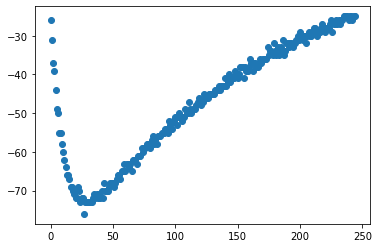

new event captured! Event Counter: 13
The experiment duration is now up to 1878.5316705703735 seconds!
retrieved 221 data points from the FIFO!


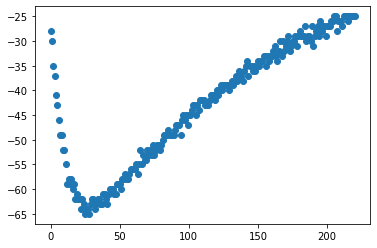

new event captured! Event Counter: 14
The experiment duration is now up to 1910.7079739570618 seconds!
retrieved 373 data points from the FIFO!


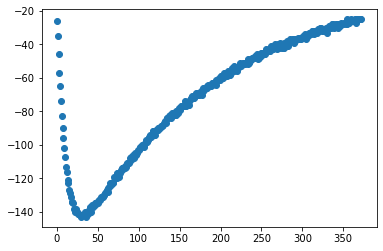

new event captured! Event Counter: 15
The experiment duration is now up to 1975.199327468872 seconds!
retrieved 594 data points from the FIFO!


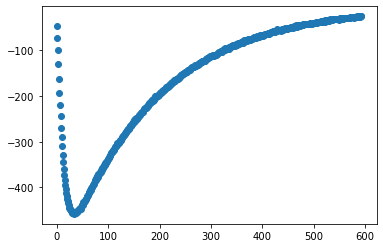

new event captured! Event Counter: 16
The experiment duration is now up to 2162.8054752349854 seconds!
retrieved 176 data points from the FIFO!


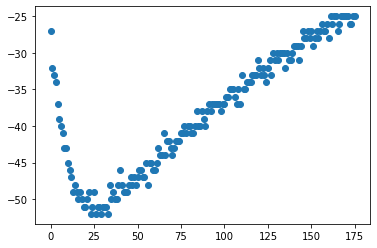

new event captured! Event Counter: 17
The experiment duration is now up to 2552.192130088806 seconds!
retrieved 136 data points from the FIFO!


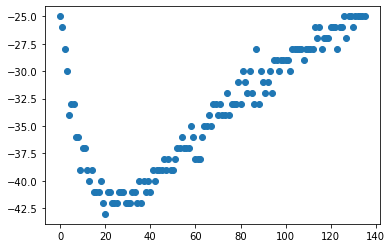

new event captured! Event Counter: 18
The experiment duration is now up to 2699.696718931198 seconds!
retrieved 241 data points from the FIFO!


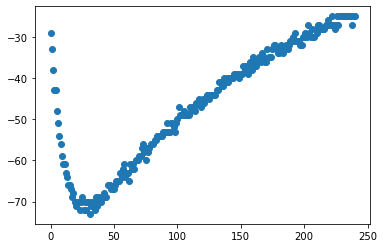

new event captured! Event Counter: 19
The experiment duration is now up to 2708.2161016464233 seconds!
retrieved 451 data points from the FIFO!


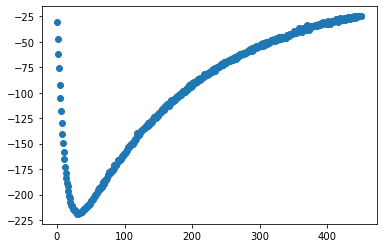

new event captured! Event Counter: 20
The experiment duration is now up to 2720.3532280921936 seconds!
retrieved 669 data points from the FIFO!


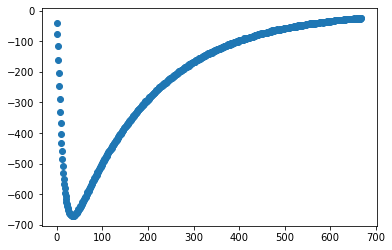

new event captured! Event Counter: 21
The experiment duration is now up to 3043.3563697338104 seconds!
retrieved 363 data points from the FIFO!


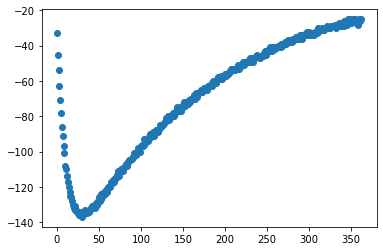

new event captured! Event Counter: 22
The experiment duration is now up to 3441.0779407024384 seconds!
retrieved 381 data points from the FIFO!


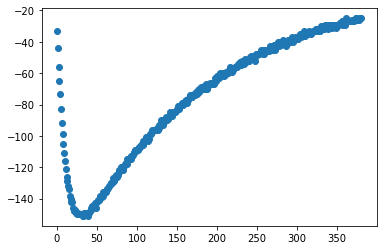

new event captured! Event Counter: 23
The experiment duration is now up to 3534.8678810596466 seconds!
retrieved 567 data points from the FIFO!


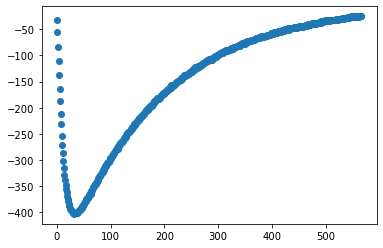

new event captured! Event Counter: 24
The experiment duration is now up to 3545.080265045166 seconds!
retrieved 160 data points from the FIFO!


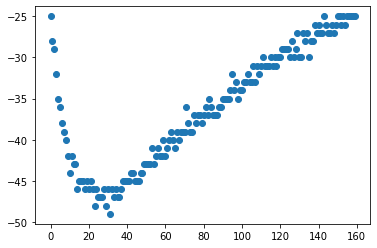

new event captured! Event Counter: 25
The experiment duration is now up to 3774.942505121231 seconds!
retrieved 388 data points from the FIFO!


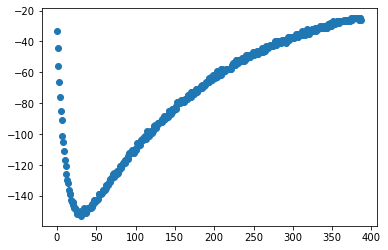

new event captured! Event Counter: 26
The experiment duration is now up to 3815.459991455078 seconds!
retrieved 439 data points from the FIFO!


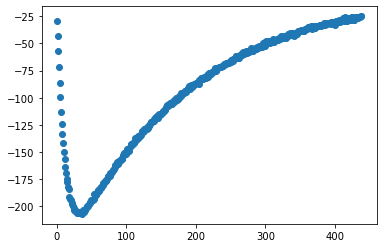

new event captured! Event Counter: 27
The experiment duration is now up to 3843.005390882492 seconds!
retrieved 95 data points from the FIFO!


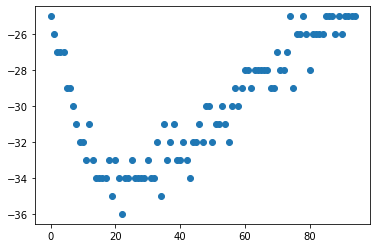

new event captured! Event Counter: 28
The experiment duration is now up to 3844.877842903137 seconds!
retrieved 494 data points from the FIFO!


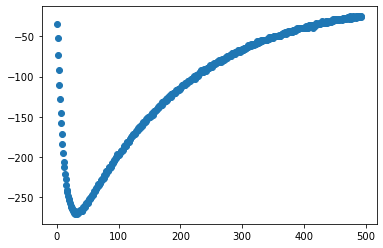

new event captured! Event Counter: 29
The experiment duration is now up to 3995.2046575546265 seconds!
retrieved 268 data points from the FIFO!


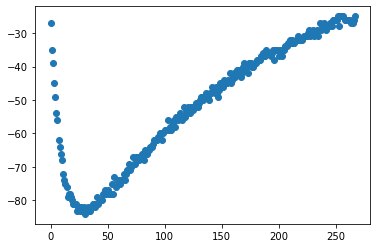

new event captured! Event Counter: 30
The experiment duration is now up to 4005.22465133667 seconds!
retrieved 308 data points from the FIFO!


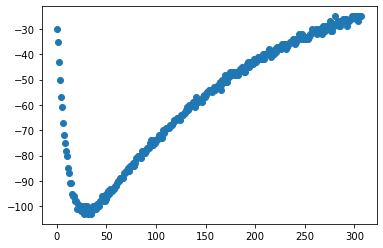

new event captured! Event Counter: 31
The experiment duration is now up to 4017.824998140335 seconds!
retrieved 461 data points from the FIFO!


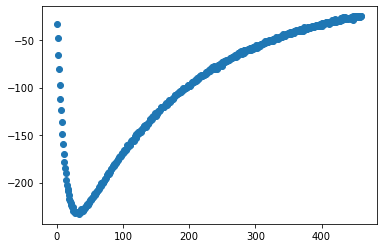

new event captured! Event Counter: 32
The experiment duration is now up to 4029.8772110939026 seconds!
retrieved 424 data points from the FIFO!


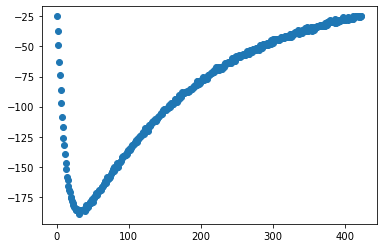

new event captured! Event Counter: 33
The experiment duration is now up to 4044.308830499649 seconds!
retrieved 196 data points from the FIFO!


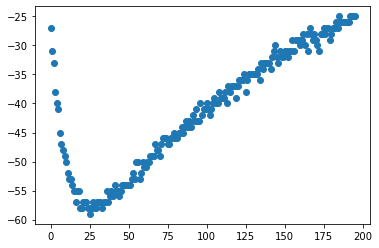

new event captured! Event Counter: 34
The experiment duration is now up to 4362.3248863220215 seconds!
retrieved 417 data points from the FIFO!


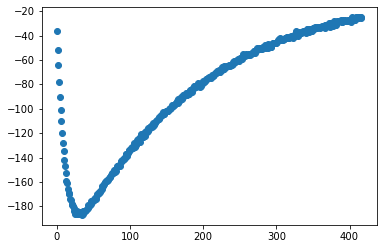

new event captured! Event Counter: 35
The experiment duration is now up to 4527.106481075287 seconds!
retrieved 563 data points from the FIFO!


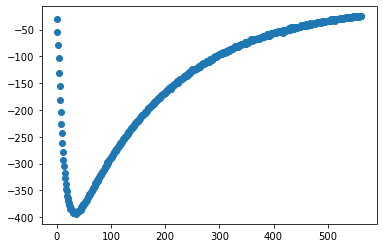

new event captured! Event Counter: 36
The experiment duration is now up to 4638.197932004929 seconds!
retrieved 692 data points from the FIFO!


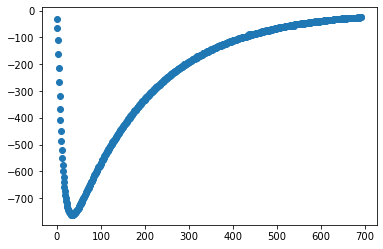

new event captured! Event Counter: 37
The experiment duration is now up to 4821.745960950851 seconds!
retrieved 81 data points from the FIFO!


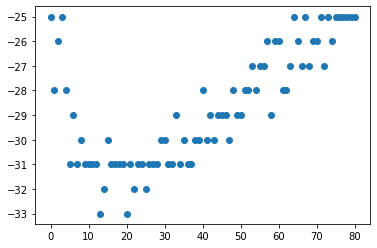

new event captured! Event Counter: 38
The experiment duration is now up to 4863.07941699028 seconds!
retrieved 407 data points from the FIFO!


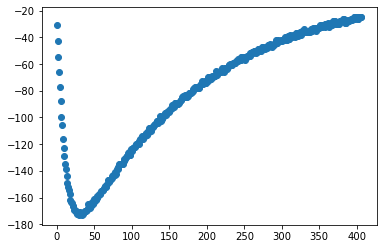

new event captured! Event Counter: 39
The experiment duration is now up to 4946.512050628662 seconds!
retrieved 274 data points from the FIFO!


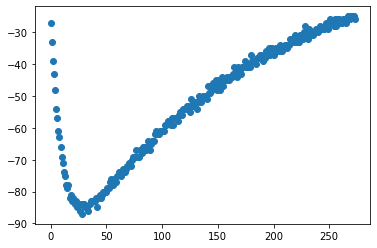

new event captured! Event Counter: 40
The experiment duration is now up to 4948.570418357849 seconds!
retrieved 928 data points from the FIFO!


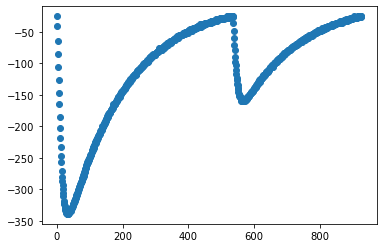

new event captured! Event Counter: 41
The experiment duration is now up to 4982.683555603027 seconds!
retrieved 459 data points from the FIFO!


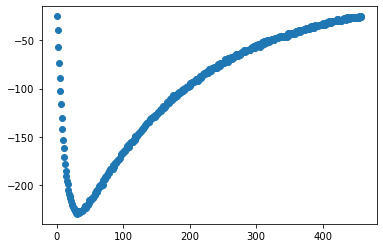

new event captured! Event Counter: 42
The experiment duration is now up to 5285.4053246974945 seconds!
retrieved 409 data points from the FIFO!


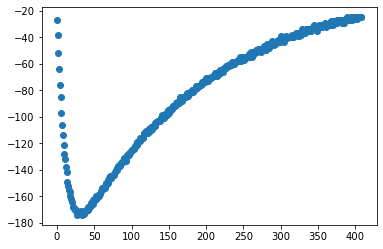

new event captured! Event Counter: 43
The experiment duration is now up to 5290.138752698898 seconds!
retrieved 465 data points from the FIFO!


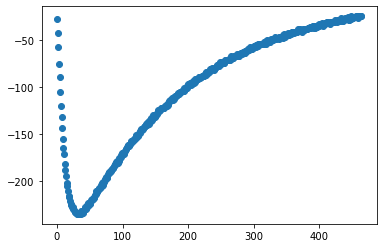

new event captured! Event Counter: 44
The experiment duration is now up to 5470.967033624649 seconds!
retrieved 386 data points from the FIFO!


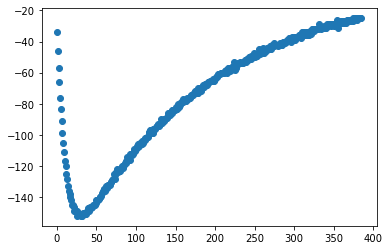

new event captured! Event Counter: 45
The experiment duration is now up to 5476.842886924744 seconds!
retrieved 380 data points from the FIFO!


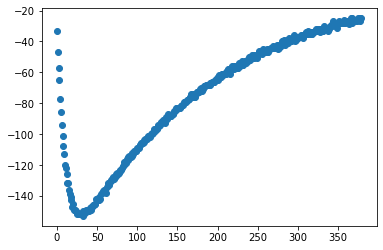

new event captured! Event Counter: 46
The experiment duration is now up to 5479.215778589249 seconds!
retrieved 507 data points from the FIFO!


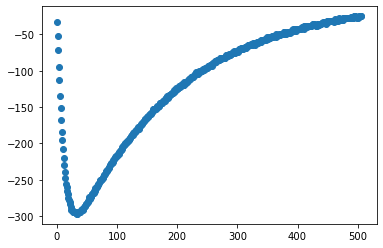

new event captured! Event Counter: 47
The experiment duration is now up to 5699.994961977005 seconds!
retrieved 88 data points from the FIFO!


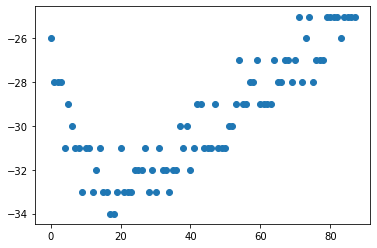

new event captured! Event Counter: 48
The experiment duration is now up to 5713.1993243694305 seconds!
retrieved 633 data points from the FIFO!


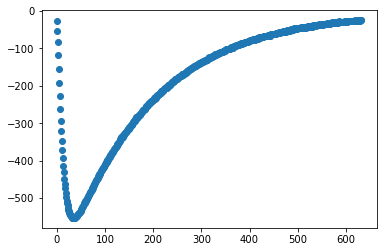

new event captured! Event Counter: 49
The experiment duration is now up to 6007.508734464645 seconds!
retrieved 628 data points from the FIFO!


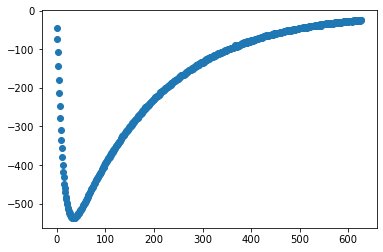

new event captured! Event Counter: 50
The experiment duration is now up to 6014.687442302704 seconds!
retrieved 331 data points from the FIFO!


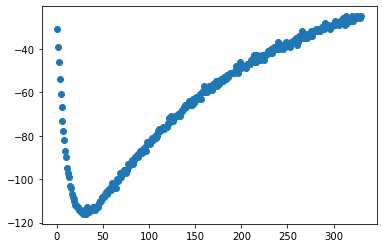

new event captured! Event Counter: 51
The experiment duration is now up to 6016.72269153595 seconds!
retrieved 492 data points from the FIFO!


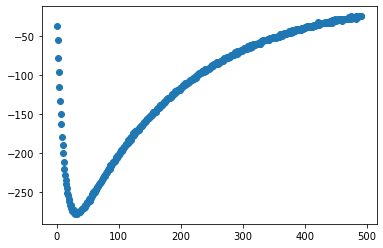

new event captured! Event Counter: 52
The experiment duration is now up to 6037.26086139679 seconds!
retrieved 649 data points from the FIFO!


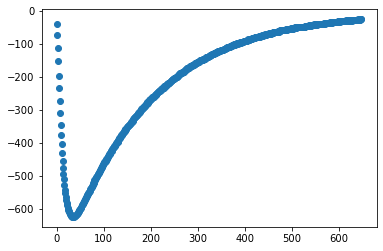

new event captured! Event Counter: 53
The experiment duration is now up to 6139.883129358292 seconds!
retrieved 94 data points from the FIFO!


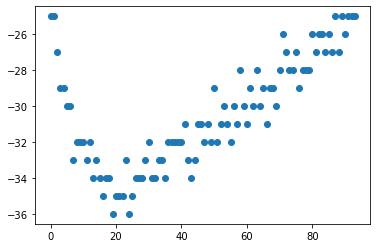

new event captured! Event Counter: 54
The experiment duration is now up to 6165.995815515518 seconds!
retrieved 708 data points from the FIFO!


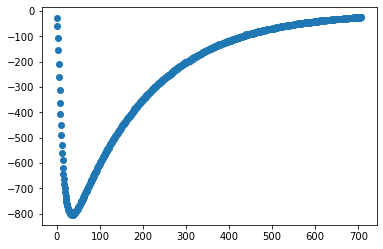

new event captured! Event Counter: 55
The experiment duration is now up to 6168.814854621887 seconds!
retrieved 571 data points from the FIFO!


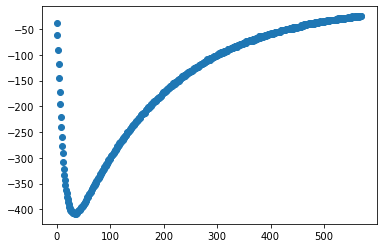

new event captured! Event Counter: 56
The experiment duration is now up to 6338.073374509811 seconds!
retrieved 483 data points from the FIFO!


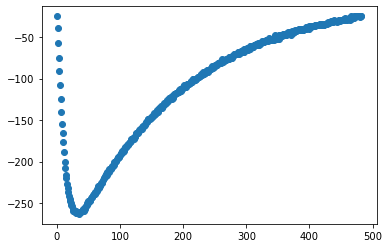

new event captured! Event Counter: 57
The experiment duration is now up to 6485.990259170532 seconds!
retrieved 361 data points from the FIFO!


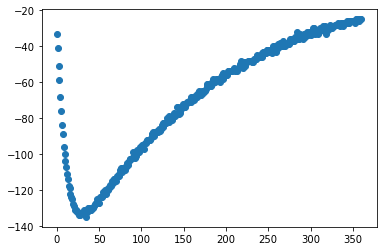

new event captured! Event Counter: 58
The experiment duration is now up to 6634.998372554779 seconds!
retrieved 293 data points from the FIFO!


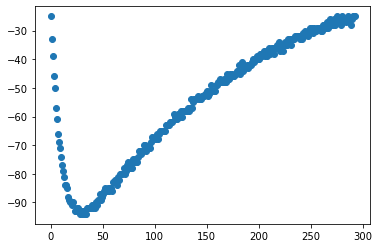

new event captured! Event Counter: 59
The experiment duration is now up to 6663.727844238281 seconds!
retrieved 576 data points from the FIFO!


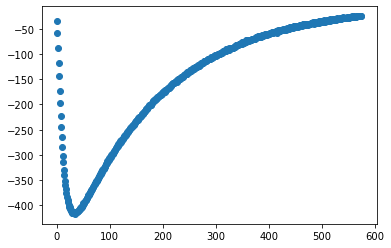

new event captured! Event Counter: 60
The experiment duration is now up to 6988.297057151794 seconds!
retrieved 550 data points from the FIFO!


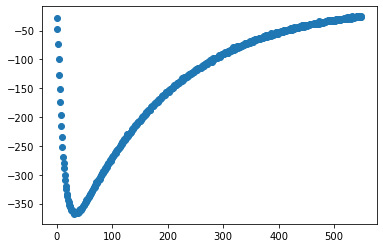

new event captured! Event Counter: 61
The experiment duration is now up to 7302.380994319916 seconds!
retrieved 474 data points from the FIFO!


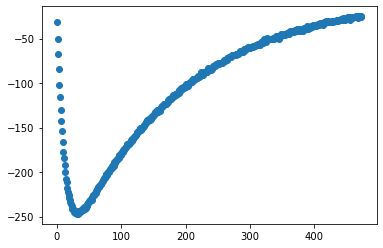

new event captured! Event Counter: 62
The experiment duration is now up to 7313.395170688629 seconds!
retrieved 466 data points from the FIFO!


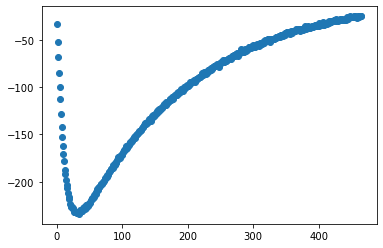

new event captured! Event Counter: 63
The experiment duration is now up to 7328.061205625534 seconds!
retrieved 653 data points from the FIFO!


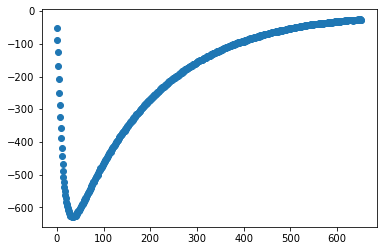

new event captured! Event Counter: 64
The experiment duration is now up to 7446.933768033981 seconds!
retrieved 320 data points from the FIFO!


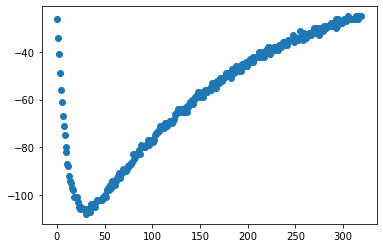

new event captured! Event Counter: 65
The experiment duration is now up to 7452.638175725937 seconds!
retrieved 537 data points from the FIFO!


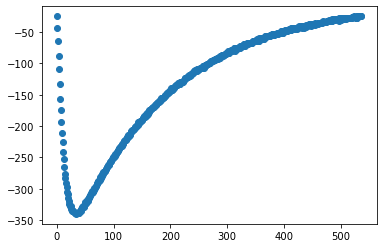

new event captured! Event Counter: 66
The experiment duration is now up to 7662.093207836151 seconds!
retrieved 314 data points from the FIFO!


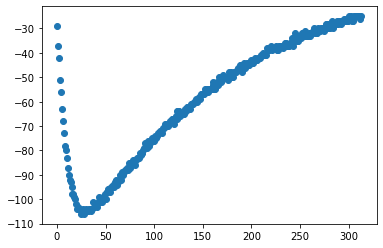

new event captured! Event Counter: 67
The experiment duration is now up to 7690.106452226639 seconds!
retrieved 352 data points from the FIFO!


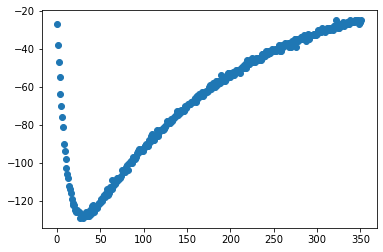

new event captured! Event Counter: 68
The experiment duration is now up to 7791.73650431633 seconds!
retrieved 434 data points from the FIFO!


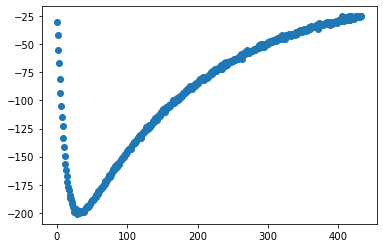

new event captured! Event Counter: 69
The experiment duration is now up to 7818.231968641281 seconds!
retrieved 633 data points from the FIFO!


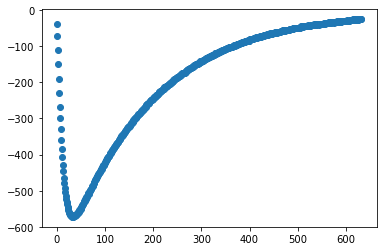

new event captured! Event Counter: 70
The experiment duration is now up to 7840.051491260529 seconds!
retrieved 15 data points from the FIFO!


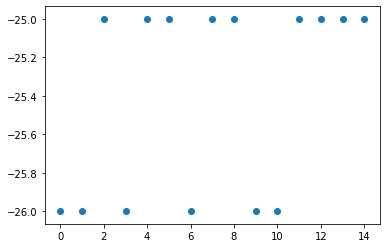

new event captured! Event Counter: 71
The experiment duration is now up to 7961.430005311966 seconds!
retrieved 84 data points from the FIFO!


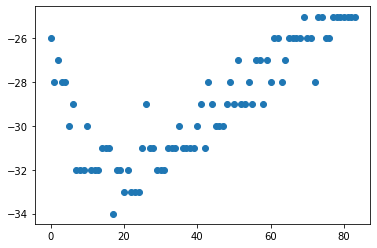

new event captured! Event Counter: 72
The experiment duration is now up to 8212.987362861633 seconds!
retrieved 282 data points from the FIFO!


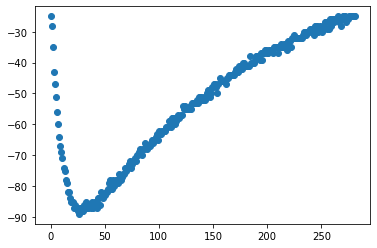

new event captured! Event Counter: 73
The experiment duration is now up to 8373.966450452805 seconds!
retrieved 106 data points from the FIFO!


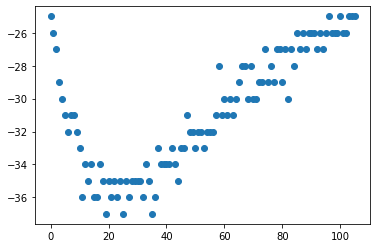

new event captured! Event Counter: 74
The experiment duration is now up to 8542.141991138458 seconds!
retrieved 504 data points from the FIFO!


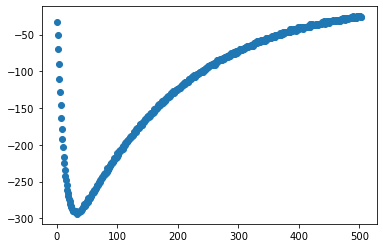

new event captured! Event Counter: 75
The experiment duration is now up to 8713.42067527771 seconds!
retrieved 342 data points from the FIFO!


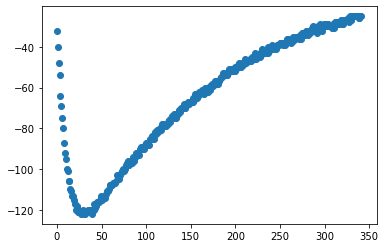

new event captured! Event Counter: 76
The experiment duration is now up to 8736.32379436493 seconds!
retrieved 496 data points from the FIFO!


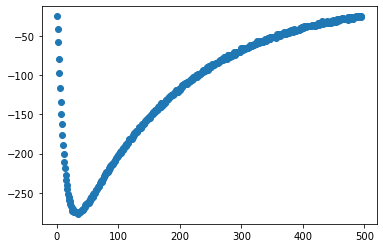

new event captured! Event Counter: 77
The experiment duration is now up to 8738.74952673912 seconds!
retrieved 232 data points from the FIFO!


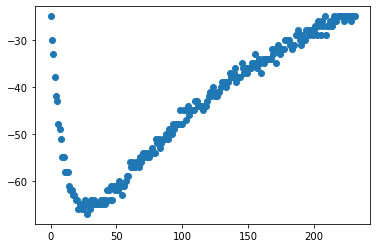

new event captured! Event Counter: 78
The experiment duration is now up to 8954.607445716858 seconds!
retrieved 460 data points from the FIFO!


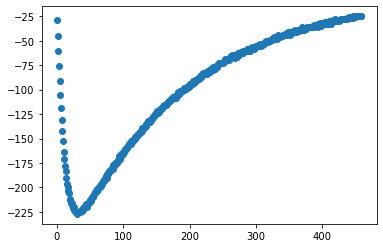

new event captured! Event Counter: 79
The experiment duration is now up to 8968.269804239273 seconds!
retrieved 463 data points from the FIFO!


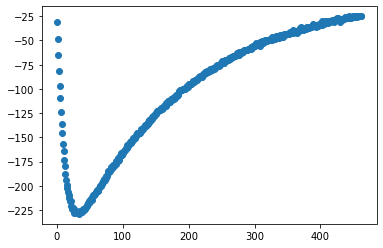

new event captured! Event Counter: 80
The experiment duration is now up to 9139.586004018784 seconds!
retrieved 671 data points from the FIFO!


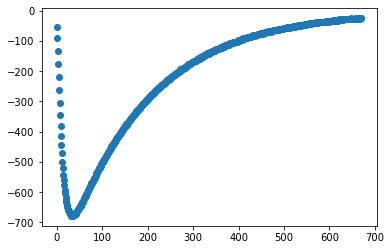

new event captured! Event Counter: 81
The experiment duration is now up to 9442.0687417984 seconds!
retrieved 349 data points from the FIFO!


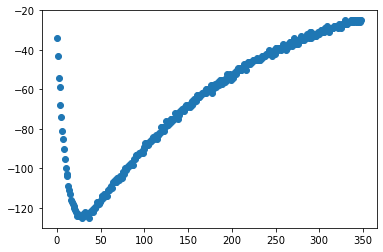

new event captured! Event Counter: 82
The experiment duration is now up to 9477.947010040283 seconds!
retrieved 572 data points from the FIFO!


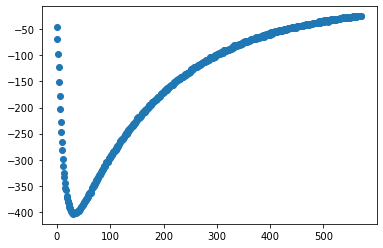

new event captured! Event Counter: 83
The experiment duration is now up to 9519.425780534744 seconds!
retrieved 177 data points from the FIFO!


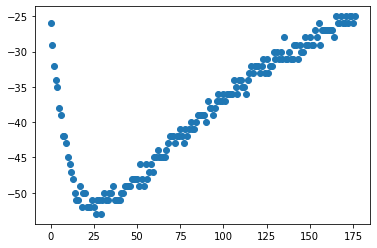

new event captured! Event Counter: 84
The experiment duration is now up to 9629.92323589325 seconds!
retrieved 221 data points from the FIFO!


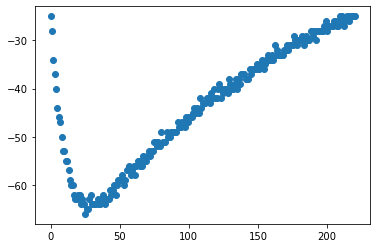

new event captured! Event Counter: 85
The experiment duration is now up to 9802.913818836212 seconds!
retrieved 206 data points from the FIFO!


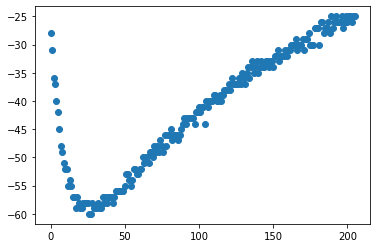

new event captured! Event Counter: 86
The experiment duration is now up to 10025.999244451523 seconds!
retrieved 409 data points from the FIFO!


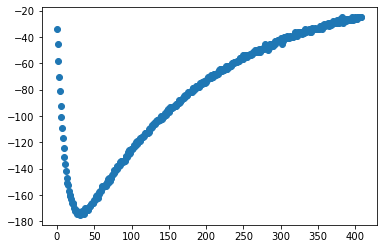

new event captured! Event Counter: 87
The experiment duration is now up to 10278.026066064835 seconds!
retrieved 669 data points from the FIFO!


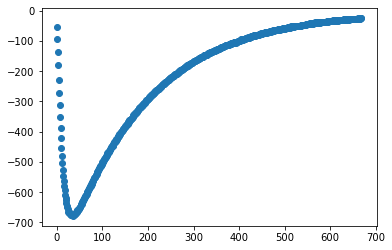

new event captured! Event Counter: 88
The experiment duration is now up to 10304.889179706573 seconds!
retrieved 714 data points from the FIFO!


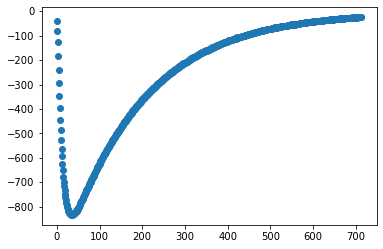

new event captured! Event Counter: 89
The experiment duration is now up to 10541.763087511063 seconds!
retrieved 204 data points from the FIFO!


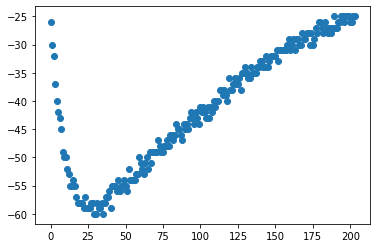

new event captured! Event Counter: 90
The experiment duration is now up to 10640.03512954712 seconds!
retrieved 244 data points from the FIFO!


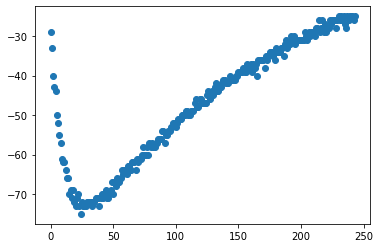

new event captured! Event Counter: 91
The experiment duration is now up to 11159.622670173645 seconds!
retrieved 604 data points from the FIFO!


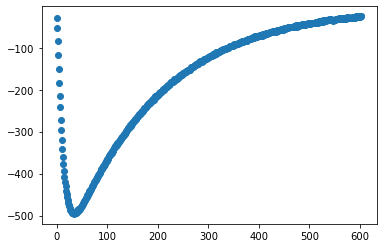

new event captured! Event Counter: 92
The experiment duration is now up to 11247.971050977707 seconds!
retrieved 604 data points from the FIFO!


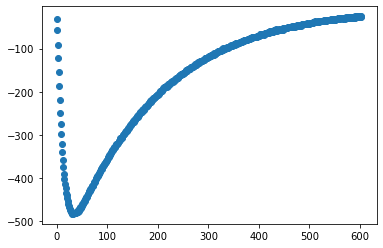

new event captured! Event Counter: 93
The experiment duration is now up to 11290.190944433212 seconds!
retrieved 198 data points from the FIFO!


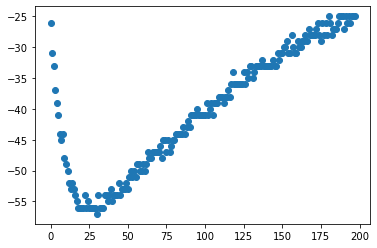

new event captured! Event Counter: 94
The experiment duration is now up to 11445.989952325821 seconds!
retrieved 501 data points from the FIFO!


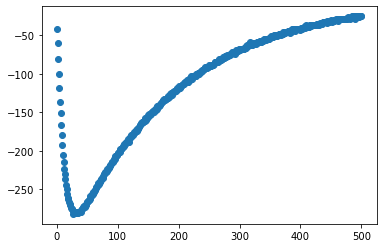

new event captured! Event Counter: 95
The experiment duration is now up to 11504.36597275734 seconds!
retrieved 276 data points from the FIFO!


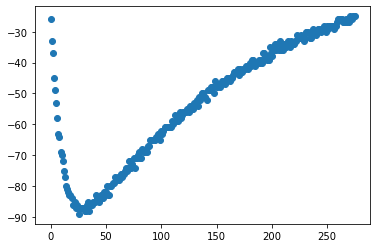

new event captured! Event Counter: 96
The experiment duration is now up to 11574.735382556915 seconds!
retrieved 493 data points from the FIFO!


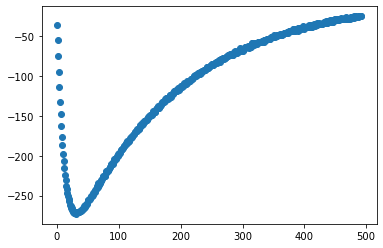

new event captured! Event Counter: 97
The experiment duration is now up to 11611.541097640991 seconds!
retrieved 139 data points from the FIFO!


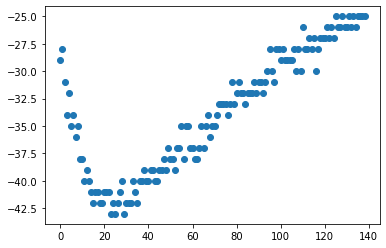

new event captured! Event Counter: 98
The experiment duration is now up to 11774.8115837574 seconds!
retrieved 627 data points from the FIFO!


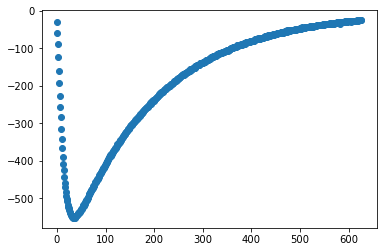

new event captured! Event Counter: 99
The experiment duration is now up to 11858.887111663818 seconds!
retrieved 390 data points from the FIFO!


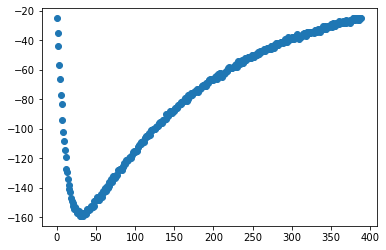

new event captured! Event Counter: 100
The experiment duration is now up to 11867.727175235748 seconds!
retrieved 575 data points from the FIFO!


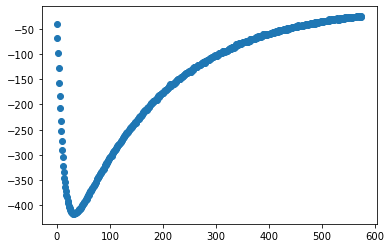

new event captured! Event Counter: 101
The experiment duration is now up to 11877.92314362526 seconds!
retrieved 177 data points from the FIFO!


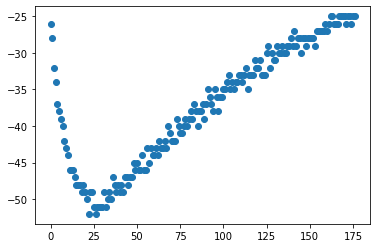

new event captured! Event Counter: 102
The experiment duration is now up to 11976.059524774551 seconds!
retrieved 571 data points from the FIFO!


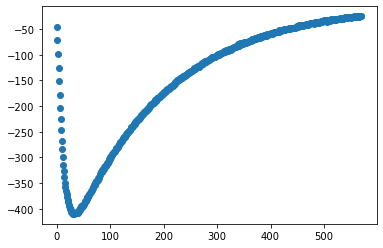

new event captured! Event Counter: 103
The experiment duration is now up to 12055.878633022308 seconds!
retrieved 593 data points from the FIFO!


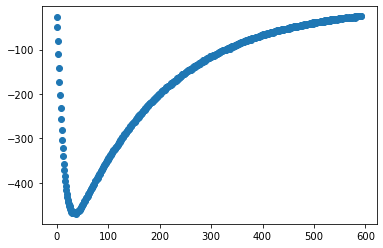

new event captured! Event Counter: 104
The experiment duration is now up to 12201.345603704453 seconds!
retrieved 356 data points from the FIFO!


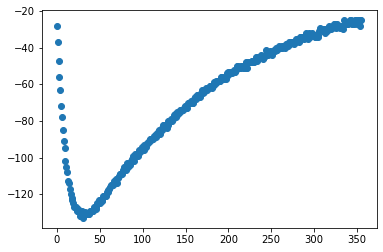

new event captured! Event Counter: 105
The experiment duration is now up to 12630.25626540184 seconds!
retrieved 468 data points from the FIFO!


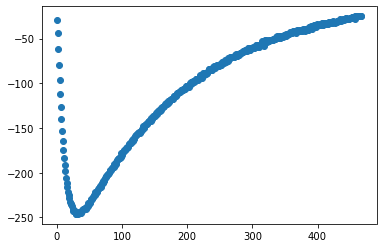

new event captured! Event Counter: 106
The experiment duration is now up to 12801.310177326202 seconds!
retrieved 393 data points from the FIFO!


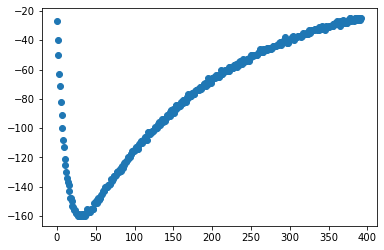

new event captured! Event Counter: 107
The experiment duration is now up to 13111.672631502151 seconds!
retrieved 487 data points from the FIFO!


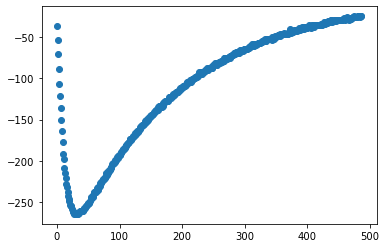

new event captured! Event Counter: 108
The experiment duration is now up to 13119.980391263962 seconds!
retrieved 226 data points from the FIFO!


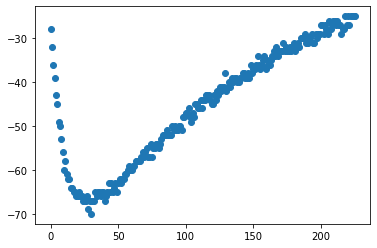

new event captured! Event Counter: 109
The experiment duration is now up to 13138.76373744011 seconds!
retrieved 179 data points from the FIFO!


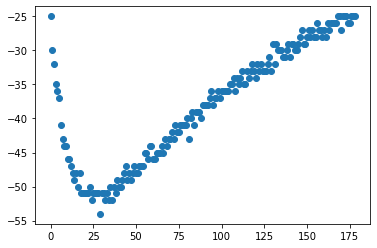

new event captured! Event Counter: 110
The experiment duration is now up to 13252.074298381805 seconds!
retrieved 290 data points from the FIFO!


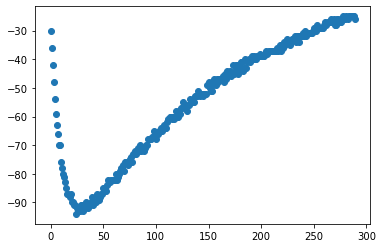

new event captured! Event Counter: 111
The experiment duration is now up to 13275.483395814896 seconds!
retrieved 415 data points from the FIFO!


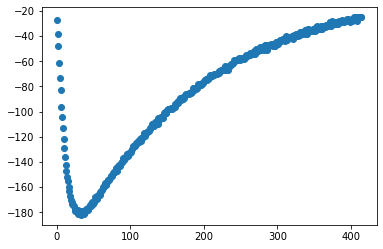

new event captured! Event Counter: 112
The experiment duration is now up to 13298.114777565002 seconds!
retrieved 580 data points from the FIFO!


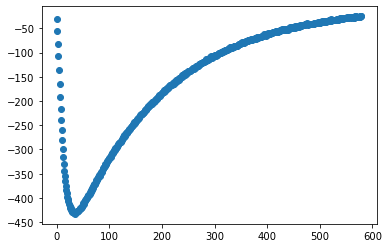

new event captured! Event Counter: 113
The experiment duration is now up to 13322.929852962494 seconds!
retrieved 11 data points from the FIFO!


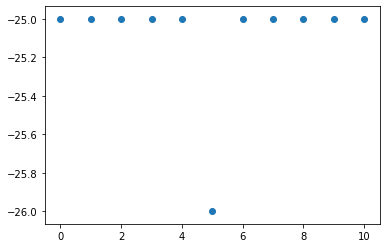

new event captured! Event Counter: 114
The experiment duration is now up to 13328.219411849976 seconds!
retrieved 331 data points from the FIFO!


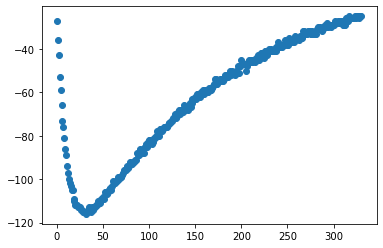

new event captured! Event Counter: 115
The experiment duration is now up to 13407.497867584229 seconds!
retrieved 402 data points from the FIFO!


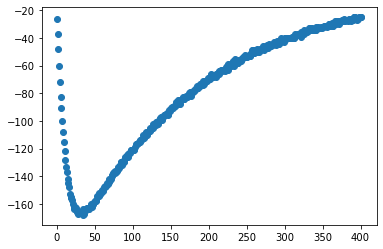

new event captured! Event Counter: 116
The experiment duration is now up to 13473.035010099411 seconds!
retrieved 50 data points from the FIFO!


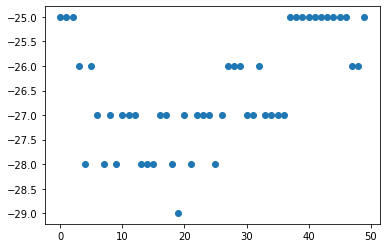

new event captured! Event Counter: 117
The experiment duration is now up to 13680.824660778046 seconds!
retrieved 151 data points from the FIFO!


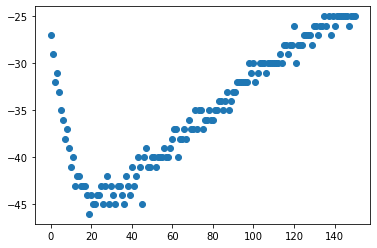

new event captured! Event Counter: 118
The experiment duration is now up to 13757.725895881653 seconds!
retrieved 454 data points from the FIFO!


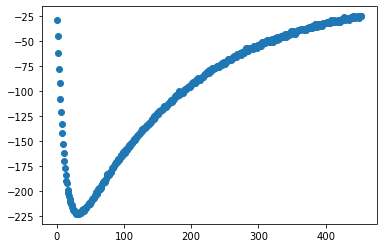

new event captured! Event Counter: 119
The experiment duration is now up to 13915.134715557098 seconds!
retrieved 15 data points from the FIFO!


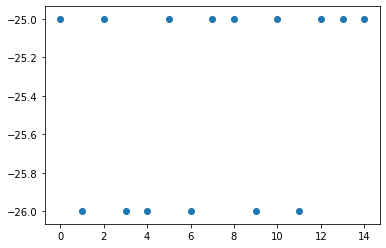

new event captured! Event Counter: 120
The experiment duration is now up to 13945.80945611 seconds!
retrieved 620 data points from the FIFO!


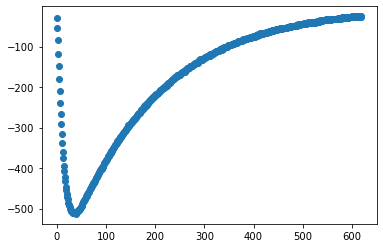

new event captured! Event Counter: 121
The experiment duration is now up to 13981.321256637573 seconds!
retrieved 471 data points from the FIFO!


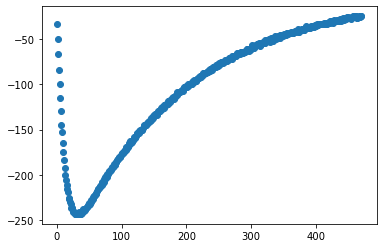

new event captured! Event Counter: 122
The experiment duration is now up to 14125.610590696335 seconds!
retrieved 452 data points from the FIFO!


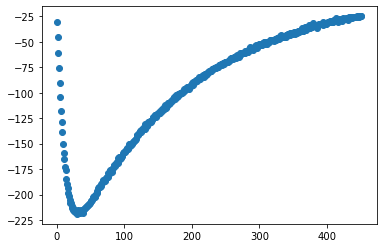

new event captured! Event Counter: 123
The experiment duration is now up to 14128.352350473404 seconds!
retrieved 298 data points from the FIFO!


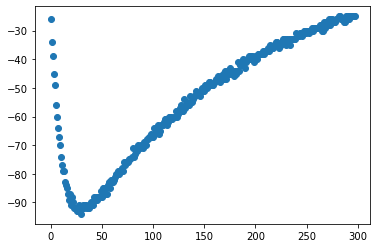

new event captured! Event Counter: 124
The experiment duration is now up to 14256.106623888016 seconds!
retrieved 443 data points from the FIFO!


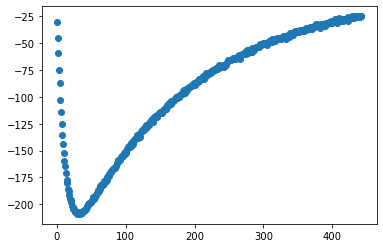

new event captured! Event Counter: 125
The experiment duration is now up to 14304.579397201538 seconds!
retrieved 528 data points from the FIFO!


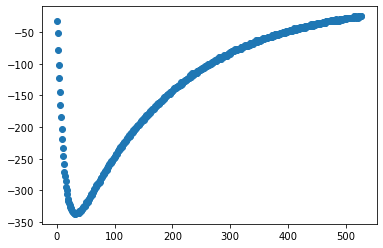

new event captured! Event Counter: 126
The experiment duration is now up to 14389.667026519775 seconds!
retrieved 204 data points from the FIFO!


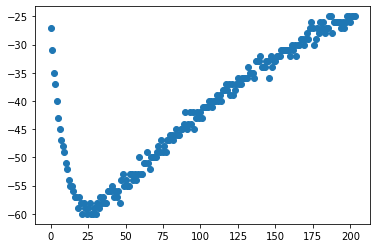

In [26]:
#run a fixed time experiment
fixed_time_experiment(n_seconds=14400, threshold=0b111111100111, threshold_direction=1)